### Data Dictionary

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer
from feature_engine import outlier_removers as outr

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [32]:
df = pd.read_csv("statenclasstrain.csv", nrows=40000)

In [33]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1504.0,34.0,0.42,1.0,1.0,3600.0,90.00,1.0,2.0,1915.0,1504.0,0.5,1681.0,80.0,95.0,1
1,1200.0,32.0,0.43,1.0,1.0,2821.0,90.00,1.0,2.0,1915.0,1200.0,0.6,1681.0,40.0,55.0,4
2,4688.0,61.0,0.34,1.0,1.0,12660.0,107.67,1.0,1.0,1915.0,1500.0,0.6,1681.0,8.0,33.0,1
3,1360.0,40.0,0.54,1.0,1.0,2500.0,100.00,1.0,2.0,1915.0,1360.0,0.6,1681.0,1.0,16.0,0
4,2248.0,48.0,0.98,1.0,1.0,2287.0,94.44,1.0,2.0,1915.0,2248.0,0.6,1681.0,22.0,37.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1600.0,40.0,0.49,1.0,1.0,8199.0,101.00,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,3
39996,2520.0,28.0,0.54,1.0,1.0,4700.0,100.00,1.0,2.0,1915.0,2520.0,0.6,1681.0,11.0,26.0,4
39997,864.0,40.0,0.17,1.0,1.0,5000.0,100.00,1.0,1.0,1915.0,864.0,0.6,1681.0,50.0,65.0,4
39998,1600.0,40.0,0.49,1.0,1.0,2225.0,91.00,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,4


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BldgArea       40000 non-null  float64
 1   BldgDepth      40000 non-null  float64
 2   BuiltFAR       40000 non-null  float64
 3   CommFAR        40000 non-null  float64
 4   FacilFAR       40000 non-null  float64
 5   LotArea        40000 non-null  float64
 6   LotDepth       40000 non-null  float64
 7   NumBldgs       40000 non-null  float64
 8   NumFloors      40000 non-null  float64
 9   OfficeArea     40000 non-null  float64
 10  ResArea        40000 non-null  float64
 11  ResidFAR       40000 non-null  float64
 12  RetailArea     40000 non-null  float64
 13  Age            40000 non-null  float64
 14  Period         40000 non-null  float64
 15  ComplaintType  40000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 4.9 MB


In [35]:
df.describe(include='all')

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.0,40000.000000,40000.000000,40000.0,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,1815.699175,39.995367,0.528688,0.998912,1.0,4400.568200,101.845558,1.0,1.842111,1909.328675,1682.243825,0.585977,1674.883425,38.879250,53.979300,1.416000
std,816.701381,10.433285,0.275605,0.023293,0.0,2834.396045,24.723134,0.0,0.347464,75.227898,676.177985,0.034722,68.942631,28.855997,28.887271,1.097463
min,100.000000,1.000000,0.010000,0.500000,1.0,10.000000,1.000000,1.0,1.000000,300.000000,216.000000,0.500000,100.000000,-23.000000,3.000000,0.000000
25%,1280.000000,33.000000,0.350000,1.000000,1.0,2500.000000,95.000000,1.0,2.000000,1915.000000,1236.000000,0.600000,1681.000000,17.000000,32.000000,1.000000
50%,1600.000000,40.000000,0.490000,1.000000,1.0,3952.000000,100.000000,1.0,2.000000,1915.000000,1500.000000,0.600000,1681.000000,35.000000,50.000000,1.000000
75%,2132.000000,46.000000,0.610000,1.000000,1.0,5040.000000,109.000000,1.0,2.000000,1915.000000,1987.000000,0.600000,1681.000000,55.000000,70.000000,2.000000
max,4688.000000,85.000000,1.390000,1.000000,1.0,12660.000000,154.320000,1.0,2.000000,1915.000000,4228.000000,0.600000,1681.000000,169.000000,184.000000,4.000000


In [36]:
df.shape

(40000, 16)

In [37]:
df.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period', 'ComplaintType'],
      dtype='object')

In [38]:
df['ComplaintType'].value_counts()

1    18741
0     7417
3     7021
2     5224
4     1597
Name: ComplaintType, dtype: int64

### Data Visualization

### Univariate Data Exploration

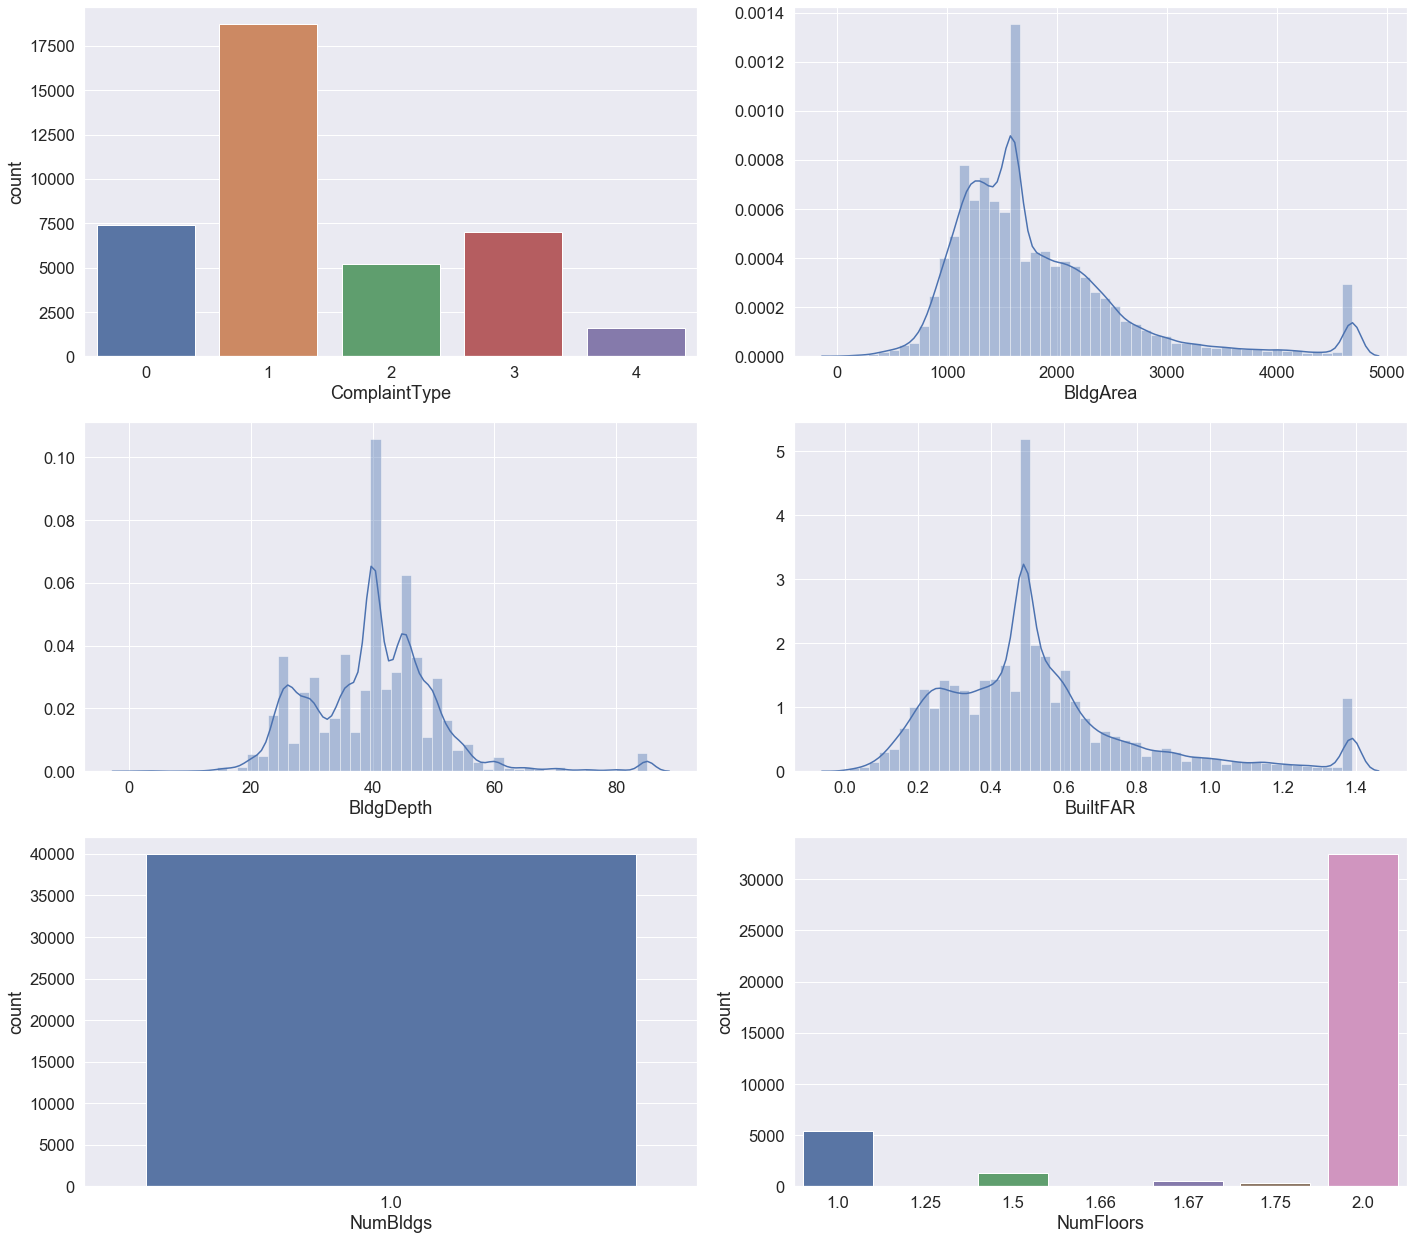

In [39]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.ComplaintType)
plt.subplot(7,2,2)
sns.distplot(df.BldgArea)
plt.subplot(7,2,3)
sns.distplot(df.BldgDepth)
plt.subplot(7,2,4)
sns.distplot(df.BuiltFAR)
plt.subplot(7,2,5)
sns.countplot(df.NumBldgs)
plt.subplot(7,2,6)
sns.countplot(df.NumFloors)
# plt.subplot(7,2,7)
# sns.countplot(df.Age)
# plt.subplot(7,2,8)
# sns.countplot(df.Period)
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [40]:
df.corr()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
BldgArea,1.000000,0.416850,0.163965,-0.003519,NaN,0.494861,0.229509,NaN,0.152985,-0.075249,0.821338,-0.079988,-0.028284,-0.086123,-0.080636,0.005046
BldgDepth,0.416850,1.000000,0.174994,-0.008765,NaN,0.079027,0.242844,NaN,-0.059311,-0.036409,0.238317,0.119452,-0.056167,-0.281512,-0.277971,-0.000222
BuiltFAR,0.163965,0.174994,1.000000,-0.003046,NaN,-0.494840,-0.434708,NaN,0.364960,-0.032174,0.132802,0.236026,-0.070674,-0.375545,-0.374469,-0.003958
CommFAR,-0.003519,-0.008765,-0.003046,1.000000,NaN,-0.004861,-0.000008,NaN,-0.014265,-0.003520,-0.002098,-0.018855,-0.004142,0.028240,0.027944,-0.001373
FacilFAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,0.494861,0.079027,-0.494840,-0.004861,NaN,1.000000,0.540809,NaN,-0.161200,-0.029865,0.386048,-0.242130,0.024124,0.186237,0.189631,0.004991
LotDepth,0.229509,0.242844,-0.434708,-0.000008,NaN,0.540809,1.000000,NaN,-0.037852,-0.006889,0.176507,-0.062053,0.004407,0.156217,0.157362,0.005250
NumBldgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumFloors,0.152985,-0.059311,0.364960,-0.014265,NaN,-0.161200,-0.037852,NaN,1.000000,0.033955,0.344150,0.152207,0.037625,-0.142353,-0.143086,0.002150
OfficeArea,-0.075249,-0.036409,-0.032174,-0.003520,NaN,-0.029865,-0.006889,NaN,0.033955,1.000000,0.009789,-0.013862,0.100618,-0.014139,-0.017456,-0.000710


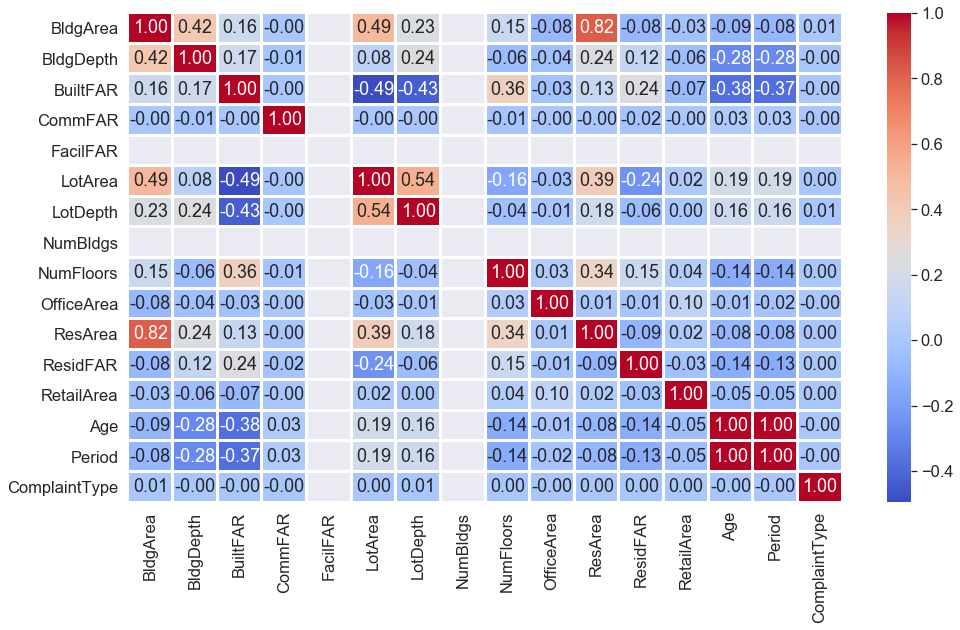

In [41]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

### Data Preprocessing

### Treat Duplicate Values

In [42]:
df.duplicated(keep='first').sum()

3707

In [43]:
df[df.duplicated(keep=False)]

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
8,1440.0,44.5,0.56,1.0,1.0,2575.0,103.00,1.0,2.0,1915.0,1440.0,0.6,1681.0,30.0,45.0,0
10,2400.0,48.0,0.63,1.0,1.0,3800.0,95.00,1.0,2.0,1915.0,2400.0,0.6,1681.0,25.0,40.0,1
12,2490.0,45.0,1.39,1.0,1.0,1520.0,47.00,1.0,2.0,1915.0,2490.0,0.6,1681.0,-4.0,11.0,1
25,1600.0,40.0,0.49,1.0,1.0,3952.0,154.32,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,1
37,2160.0,67.0,1.29,1.0,1.0,1680.0,105.00,1.0,2.0,1915.0,2160.0,0.6,1681.0,8.0,23.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39969,1633.0,45.0,0.77,1.0,1.0,2130.0,99.00,1.0,2.0,1915.0,695.0,0.6,938.0,5.0,20.0,0
39973,1156.0,35.0,0.47,1.0,1.0,2475.0,90.00,1.0,2.0,1915.0,1156.0,0.6,1681.0,40.0,55.0,2
39978,1600.0,40.0,0.49,1.0,1.0,5000.0,100.00,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,4
39981,1600.0,40.0,0.49,1.0,1.0,12660.0,154.32,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,3


In [ ]:
df.drop_duplicates(keep='first',ignore_index=True, inplace=True)

In [ ]:
df

### HEAT/HOT WATER = 0; OTHERS = 1, PAINT/PLASTER = 2, PLUMBING = 3, UNSANITARY CONDITION = 4

### Train Test Split

In [44]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

### Treat Imbalance Data

In [45]:
y.value_counts()

1    18741
0     7417
3     7021
2     5224
4     1597
Name: ComplaintType, dtype: int64

In [46]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [47]:
new_X, new_y = ros.fit_resample(X, y)

In [48]:
new_y.value_counts()

4    18741
3    18741
2    18741
1    18741
0    18741
Name: ComplaintType, dtype: int64

In [49]:
new_X

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period
0,1504.0,34.0,0.42,1.0,1.0,3600.0,90.00,1.0,2.0,1915.0,1504.0,0.5,1681.0,80.0,95.0
1,1200.0,32.0,0.43,1.0,1.0,2821.0,90.00,1.0,2.0,1915.0,1200.0,0.6,1681.0,40.0,55.0
2,4688.0,61.0,0.34,1.0,1.0,12660.0,107.67,1.0,1.0,1915.0,1500.0,0.6,1681.0,8.0,33.0
3,1360.0,40.0,0.54,1.0,1.0,2500.0,100.00,1.0,2.0,1915.0,1360.0,0.6,1681.0,1.0,16.0
4,2248.0,48.0,0.98,1.0,1.0,2287.0,94.44,1.0,2.0,1915.0,2248.0,0.6,1681.0,22.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93700,2618.0,39.0,0.52,1.0,1.0,5000.0,100.00,1.0,2.0,1915.0,2618.0,0.6,1681.0,-10.0,5.0
93701,1504.0,30.0,0.15,1.0,1.0,10000.0,100.00,1.0,2.0,1915.0,1504.0,0.5,1681.0,95.0,110.0
93702,968.0,26.0,0.48,1.0,1.0,2000.0,80.00,1.0,2.0,1915.0,968.0,0.5,1681.0,85.0,100.0
93703,1300.0,38.0,0.39,1.0,1.0,3360.0,84.00,1.0,1.5,1915.0,1300.0,0.5,1681.0,80.0,95.0


In [50]:
new_X.values, new_y.values

(array([[1.504e+03, 3.400e+01, 4.200e-01, ..., 1.681e+03, 8.000e+01,
         9.500e+01],
        [1.200e+03, 3.200e+01, 4.300e-01, ..., 1.681e+03, 4.000e+01,
         5.500e+01],
        [4.688e+03, 6.100e+01, 3.400e-01, ..., 1.681e+03, 8.000e+00,
         3.300e+01],
        ...,
        [9.680e+02, 2.600e+01, 4.800e-01, ..., 1.681e+03, 8.500e+01,
         1.000e+02],
        [1.300e+03, 3.800e+01, 3.900e-01, ..., 1.681e+03, 8.000e+01,
         9.500e+01],
        [1.440e+03, 2.400e+01, 4.800e-01, ..., 1.681e+03, 2.500e+01,
         4.000e+01]]),
 array([1, 4, 1, ..., 4, 4, 4], dtype=int64))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [52]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((74964, 15), (18741, 15), (74964,), (18741,))

### Feature Scaling

In [53]:
X_train

array([[1.188e+03, 5.000e+01, 3.600e-01, ..., 1.681e+03, 3.000e+01,
        4.500e+01],
       [1.248e+03, 2.100e+01, 3.000e-01, ..., 1.681e+03, 3.500e+01,
        5.000e+01],
       [1.720e+03, 4.500e+01, 1.210e+00, ..., 1.681e+03, 1.400e+01,
        2.900e+01],
       ...,
       [1.350e+03, 4.500e+01, 9.000e-01, ..., 1.681e+03, 1.000e+00,
        1.600e+01],
       [1.152e+03, 3.400e+01, 4.500e-01, ..., 1.681e+03, 4.500e+01,
        6.000e+01],
       [7.900e+02, 3.400e+01, 1.100e-01, ..., 1.681e+03, 6.500e+01,
        8.000e+01]])

In [54]:
scaler = StandardScaler()

In [55]:
X_train_scaled = scaler.fit_transform(X_train)

In [56]:
X_test_scaled = scaler.transform(X_test)

In [57]:
X_train_scaled

array([[-0.76613015,  0.95546394, -0.61011311, ...,  0.08884566,
        -0.30956653, -0.31253137],
       [-0.69299817, -1.82212986, -0.8270435 , ...,  0.08884566,
        -0.13584995, -0.13898437],
       [-0.11769321,  0.47656845,  2.46306744, ...,  0.08884566,
        -0.86545955, -0.86788176],
       ...,
       [-0.56867379,  0.47656845,  1.34226042, ...,  0.08884566,
        -1.31712263, -1.31910396],
       [-0.81000934, -0.57700161, -0.28471752, ...,  0.08884566,
         0.21158319,  0.20810962],
       [-1.25123899, -0.57700161, -1.51398974, ...,  0.08884566,
         0.90644947,  0.90229761]])

In [58]:
X_test_scaled

array([[-0.26395718, -0.00232703, -0.14009726, ...,  0.08884566,
        -0.13584995, -0.13898437],
       [-0.26395718, -0.00232703, -0.14009726, ...,  0.08884566,
        -0.13584995, -0.13898437],
       [ 1.48389728, -0.57700161, -1.18859416, ...,  0.08884566,
         2.26143872,  2.25596419],
       ...,
       [-0.57598699,  0.76390574,  0.36607365, ...,  0.08884566,
        -0.96968949, -0.97200996],
       [-0.86729607, -1.43901348, -1.29705935, ...,  0.08884566,
         0.55901633,  0.55520362],
       [-0.71493776, -0.7685598 ,  0.25760846, ...,  0.08884566,
         0.21158319,  0.20810962]])

In [59]:
y_train

array([1, 4, 2, ..., 0, 0, 3], dtype=int64)

In [60]:
y_test

array([0, 2, 2, ..., 2, 3, 4], dtype=int64)

### Model Training

### Using XGBoost (Scikit-Learn)

In [61]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=300, objective='multi:softmax')

In [62]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='merror',early_stopping_rounds=10)

[0]	validation_0-merror:0.789019
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.785337
[2]	validation_0-merror:0.784537
[3]	validation_0-merror:0.782509
[4]	validation_0-merror:0.780001
[5]	validation_0-merror:0.775092
[6]	validation_0-merror:0.775466
[7]	validation_0-merror:0.773171
[8]	validation_0-merror:0.77109
[9]	validation_0-merror:0.77141
[10]	validation_0-merror:0.76997
[11]	validation_0-merror:0.769543
[12]	validation_0-merror:0.769062
[13]	validation_0-merror:0.769169
[14]	validation_0-merror:0.768422
[15]	validation_0-merror:0.765381
[16]	validation_0-merror:0.762606
[17]	validation_0-merror:0.762339
[18]	validation_0-merror:0.761112
[19]	validation_0-merror:0.761539
[20]	validation_0-merror:0.761272
[21]	validation_0-merror:0.761859
[22]	validation_0-merror:0.760845
[23]	validation_0-merror:0.759511
[24]	validation_0-merror:0.760792
[25]	validation_0-merror:0.759938
[26]	validation_0-merror:0.760792
[27]	validation_0-merror:0.7

[236]	validation_0-merror:0.694627
[237]	validation_0-merror:0.694573
[238]	validation_0-merror:0.694627
[239]	validation_0-merror:0.69436
[240]	validation_0-merror:0.69484
[241]	validation_0-merror:0.694787
[242]	validation_0-merror:0.694947
[243]	validation_0-merror:0.695
[244]	validation_0-merror:0.69356
[245]	validation_0-merror:0.694413
[246]	validation_0-merror:0.693933
[247]	validation_0-merror:0.694413
[248]	validation_0-merror:0.69452
[249]	validation_0-merror:0.694253
[250]	validation_0-merror:0.693186
[251]	validation_0-merror:0.693826
[252]	validation_0-merror:0.692813
[253]	validation_0-merror:0.692759
[254]	validation_0-merror:0.691692
[255]	validation_0-merror:0.691212
[256]	validation_0-merror:0.690571
[257]	validation_0-merror:0.690732
[258]	validation_0-merror:0.690678
[259]	validation_0-merror:0.690732
[260]	validation_0-merror:0.689985
[261]	validation_0-merror:0.690518
[262]	validation_0-merror:0.690305
[263]	validation_0-merror:0.690945
[264]	validation_0-merror:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [63]:
y_pred = xgbmodel.predict(X_test_scaled)

In [64]:
y_pred

array([3, 3, 1, ..., 4, 2, 0], dtype=int64)

### Model Evaluation

In [65]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[1213,  466,  579,  623,  827],
       [ 861,  580,  668,  660,  924],
       [ 754,  524, 1079,  588,  906],
       [ 808,  507,  653,  946,  846],
       [ 535,  316,  392,  408, 2078]], dtype=int64)

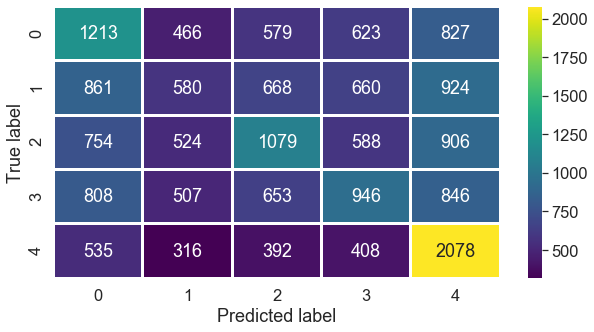

In [66]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.29      0.33      0.31      3708
           1       0.24      0.16      0.19      3693
           2       0.32      0.28      0.30      3851
           3       0.29      0.25      0.27      3760
           4       0.37      0.56      0.45      3729

    accuracy                           0.31     18741
   macro avg       0.30      0.31      0.30     18741
weighted avg       0.30      0.31      0.30     18741



### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [68]:
X.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period'],
      dtype='object')

In [69]:
xgbmodel.get_booster().feature_names = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea','ResidFAR', 'RetailArea', 'Age', 'Period']

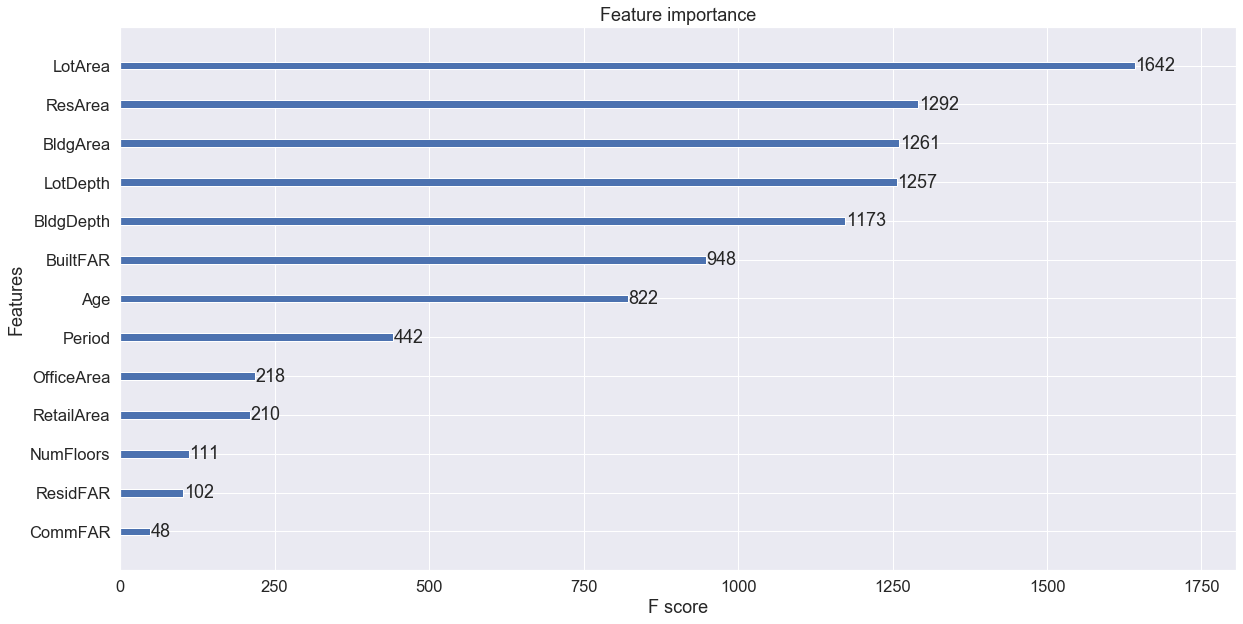

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

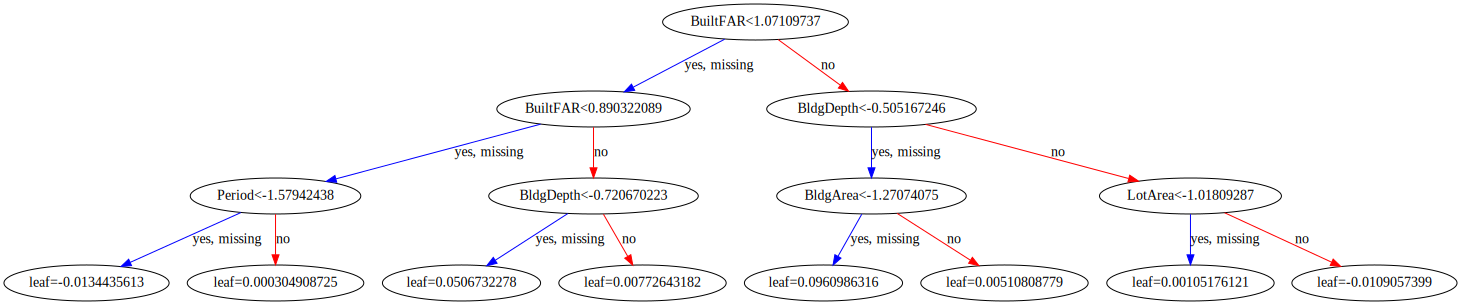

In [72]:
xgb.to_graphviz(xgbmodel,num_trees=200)

### Cross-Validation

In [73]:
cv = cross_val_score(xgbmodel,X_train_scaled,y_train,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished


In [74]:
cv.mean()

0.3091351355285615

### Using XGBoost (API)

{'subsample': 0.7,
 'n_estimators': 400,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.6}

In [75]:
dtrain = xgb.DMatrix(data=X_train_scaled,label=y_train)
dtest = xgb.DMatrix(data=X_test_scaled,label=y_test)

In [76]:
params = {'n_estimators': 700,
          'learning_rate': 0.2,
          'max_depth': 6,
          'min_child_weight': 3,
          'objective': 'multi:softmax',
          'num_class': 5 ,
          'seed': 0,
          'colsample_bytree': 0.6,
          'subsample' : 0.7,
          'gamma' : 0,
          'eval_metric':'merror'}

In [78]:
xgbmodel = xgb.train(params=params,dtrain=dtrain,num_boost_round=700,evals=[(dtest,"Test")],
                     early_stopping_rounds=10)

[0]	Test-merror:0.762553
Will train until Test-merror hasn't improved in 10 rounds.
[1]	Test-merror:0.754335
[2]	Test-merror:0.747292
[3]	Test-merror:0.733365
[4]	Test-merror:0.726802
[5]	Test-merror:0.720452
[6]	Test-merror:0.711381
[7]	Test-merror:0.711061
[8]	Test-merror:0.707753
[9]	Test-merror:0.703218
[10]	Test-merror:0.705085
[11]	Test-merror:0.70151
[12]	Test-merror:0.695694
[13]	Test-merror:0.691052
[14]	Test-merror:0.68833
[15]	Test-merror:0.687637
[16]	Test-merror:0.682941
[17]	Test-merror:0.677445
[18]	Test-merror:0.675578
[19]	Test-merror:0.671629
[20]	Test-merror:0.669335
[21]	Test-merror:0.665119
[22]	Test-merror:0.663999
[23]	Test-merror:0.65989
[24]	Test-merror:0.658823
[25]	Test-merror:0.655835
[26]	Test-merror:0.65322
[27]	Test-merror:0.651406
[28]	Test-merror:0.647778
[29]	Test-merror:0.644896
[30]	Test-merror:0.642655
[31]	Test-merror:0.63924
[32]	Test-merror:0.637746
[33]	Test-merror:0.633264
[34]	Test-merror:0.63289
[35]	Test-merror:0.630329
[36]	Test-merror:0.62

[307]	Test-merror:0.43034
[308]	Test-merror:0.4313
[309]	Test-merror:0.43098
[310]	Test-merror:0.430607
[311]	Test-merror:0.428846
[312]	Test-merror:0.428846
[313]	Test-merror:0.429433
[314]	Test-merror:0.429806
[315]	Test-merror:0.429913
[316]	Test-merror:0.429166
[317]	Test-merror:0.428846
[318]	Test-merror:0.427992
[319]	Test-merror:0.428419
[320]	Test-merror:0.427245
[321]	Test-merror:0.427245
[322]	Test-merror:0.427725
[323]	Test-merror:0.426711
[324]	Test-merror:0.427405
[325]	Test-merror:0.425644
[326]	Test-merror:0.425431
[327]	Test-merror:0.425858
[328]	Test-merror:0.42431
[329]	Test-merror:0.423777
[330]	Test-merror:0.422496
[331]	Test-merror:0.421856
[332]	Test-merror:0.422123
[333]	Test-merror:0.422656
[334]	Test-merror:0.422603
[335]	Test-merror:0.422389
[336]	Test-merror:0.422069
[337]	Test-merror:0.421963
[338]	Test-merror:0.419935
[339]	Test-merror:0.420202
[340]	Test-merror:0.418548
[341]	Test-merror:0.418654
[342]	Test-merror:0.418441
[343]	Test-merror:0.417907
[344]	

In [79]:
y_pred = xgbmodel.predict(dtest)

In [80]:
y_pred

array([0., 2., 2., ..., 2., 3., 4.], dtype=float32)

### Cross-Validation (API)

In [81]:
 cv = xgb.cv(params=params,
             dtrain=dtrain,
             num_boost_round=600,
             nfold=5,
             stratified=False,
             folds=None,
             metrics=('merror'),
             obj=None,
             feval=None,
             maximize=False,
             early_stopping_rounds=10,
             fpreproc=None,
             as_pandas=True,
             verbose_eval=None,
             show_stdv=True,
             seed=0,
             callbacks=None,
             shuffle=True,)

In [82]:
cv

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.757307,0.002409,0.773478,0.002961
1,0.735860,0.003558,0.756243,0.003921
2,0.722270,0.004554,0.748679,0.003366
3,0.709584,0.004617,0.739568,0.005391
4,0.699275,0.003336,0.731805,0.004930
...,...,...,...,...
595,0.207003,0.000506,0.380663,0.004828
596,0.206966,0.000366,0.380849,0.005024
597,0.206596,0.000403,0.380249,0.004695
598,0.206469,0.000747,0.380262,0.004446


In [83]:
cv['test-merror-mean'].min()

0.3800892

### Model Evaluation

In [84]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[2244,  516,  335,  413,  200],
       [ 785, 1253,  595,  743,  317],
       [ 368,  443, 2524,  338,  178],
       [ 357,  609,  339, 2263,  192],
       [  43,   48,   29,  102, 3507]], dtype=int64)

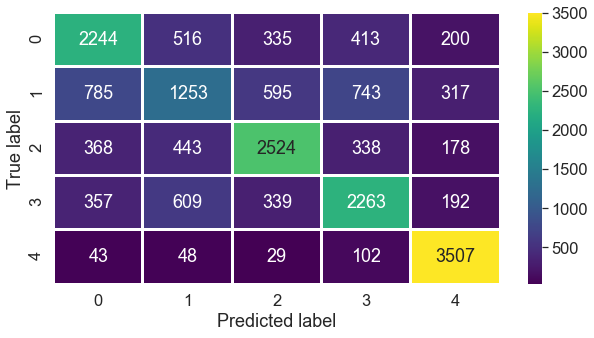

In [85]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [86]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.61      0.60      3708
           1       0.44      0.34      0.38      3693
           2       0.66      0.66      0.66      3851
           3       0.59      0.60      0.59      3760
           4       0.80      0.94      0.86      3729

    accuracy                           0.63     18741
   macro avg       0.61      0.63      0.62     18741
weighted avg       0.62      0.63      0.62     18741



### Model Tuning

### Using RandomSearchCV

In [3]:
df = pd.read_csv("statenclasstrain.csv", nrows=2000)

In [4]:
df.duplicated(keep='first').sum()

40

In [5]:
df[df.duplicated(keep=False)]

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
61,1600.0,40.00,0.49,1.0,1.0,6000.0,100.00,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,0
73,1354.0,25.83,1.39,1.0,1.0,500.0,25.83,1.0,2.0,1915.0,1354.0,0.6,1681.0,9.0,24.0,1
87,1600.0,40.00,0.49,1.0,1.0,4000.0,100.00,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,0
111,1600.0,40.00,0.49,1.0,1.0,12660.0,154.32,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,1
118,1600.0,40.00,0.49,1.0,1.0,12660.0,154.32,1.0,2.0,1915.0,1500.0,0.5,1681.0,35.0,50.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,1344.0,42.00,0.57,1.0,1.0,2375.0,95.00,1.0,2.0,1915.0,1344.0,0.6,1681.0,25.0,40.0,0
1895,1600.0,40.00,0.49,1.0,1.0,12660.0,154.32,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,0
1931,1300.0,45.00,0.71,1.0,1.0,1820.0,130.00,1.0,2.0,1915.0,1300.0,0.6,1681.0,0.0,15.0,0
1969,1600.0,40.00,0.49,1.0,1.0,12660.0,154.32,1.0,2.0,1915.0,1500.0,0.6,1681.0,35.0,50.0,0


In [6]:
df.drop_duplicates(keep='first',ignore_index=True, inplace=True)

In [7]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1504.0,34.0,0.42,1.0,1.0,3600.0,90.00,1.0,2.0,1915.0,1504.0,0.5,1681.0,80.0,95.0,1
1,1200.0,32.0,0.43,1.0,1.0,2821.0,90.00,1.0,2.0,1915.0,1200.0,0.6,1681.0,40.0,55.0,4
2,4688.0,61.0,0.34,1.0,1.0,12660.0,107.67,1.0,1.0,1915.0,1500.0,0.6,1681.0,8.0,33.0,1
3,1360.0,40.0,0.54,1.0,1.0,2500.0,100.00,1.0,2.0,1915.0,1360.0,0.6,1681.0,1.0,16.0,0
4,2248.0,48.0,0.98,1.0,1.0,2287.0,94.44,1.0,2.0,1915.0,2248.0,0.6,1681.0,22.0,37.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,1216.0,26.0,0.43,1.0,1.0,2850.0,114.00,1.0,2.0,1915.0,1216.0,0.6,1681.0,70.0,85.0,3
1956,1144.0,44.0,0.29,1.0,1.0,4000.0,100.00,1.0,1.0,1915.0,1144.0,0.5,1681.0,45.0,60.0,0
1957,1596.0,26.0,0.32,1.0,1.0,5000.0,100.00,1.0,2.0,1915.0,1596.0,0.6,1681.0,75.0,90.0,0
1958,1542.0,23.0,0.82,1.0,1.0,1890.0,60.98,1.0,2.0,1915.0,1542.0,0.6,1681.0,9.0,24.0,0


### HEAT/HOT WATER = 0; OTHERS = 1, PAINT/PLASTER = 2, PLUMBING = 3, UNSANITARY CONDITION = 4

### Train Test Split

In [8]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

In [9]:
y.value_counts()

0    723
1    570
4    356
3    192
2    119
Name: ComplaintType, dtype: int64

In [10]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [11]:
new_X, new_y = ros.fit_resample(X, y)

In [12]:
new_y.value_counts()

3    723
1    723
4    723
2    723
0    723
Name: ComplaintType, dtype: int64

In [13]:
new_X

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period
0,1504.0,34.0,0.42,1.0,1.0,3600.0,90.00,1.0,2.0,1915.0,1504.0,0.5,1681.0,80.0,95.0
1,1200.0,32.0,0.43,1.0,1.0,2821.0,90.00,1.0,2.0,1915.0,1200.0,0.6,1681.0,40.0,55.0
2,4688.0,61.0,0.34,1.0,1.0,12660.0,107.67,1.0,1.0,1915.0,1500.0,0.6,1681.0,8.0,33.0
3,1360.0,40.0,0.54,1.0,1.0,2500.0,100.00,1.0,2.0,1915.0,1360.0,0.6,1681.0,1.0,16.0
4,2248.0,48.0,0.98,1.0,1.0,2287.0,94.44,1.0,2.0,1915.0,2248.0,0.6,1681.0,22.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,900.0,30.0,0.48,1.0,1.0,1864.0,60.00,1.0,2.0,1915.0,900.0,0.6,1681.0,8.0,23.0
3611,1260.0,45.0,0.54,1.0,1.0,2328.0,95.00,1.0,2.0,1915.0,1260.0,0.6,1681.0,4.0,19.0
3612,1566.0,50.0,0.41,1.0,1.0,3780.0,135.00,1.0,2.0,1915.0,1566.0,0.6,1681.0,7.0,22.0
3613,1040.0,27.0,0.32,1.0,1.0,3240.0,81.00,1.0,1.0,1915.0,1040.0,0.6,1681.0,30.0,45.0


In [14]:
new_X.values, new_y.values

(array([[1.504e+03, 3.400e+01, 4.200e-01, ..., 1.681e+03, 8.000e+01,
         9.500e+01],
        [1.200e+03, 3.200e+01, 4.300e-01, ..., 1.681e+03, 4.000e+01,
         5.500e+01],
        [4.688e+03, 6.100e+01, 3.400e-01, ..., 1.681e+03, 8.000e+00,
         3.300e+01],
        ...,
        [1.566e+03, 5.000e+01, 4.100e-01, ..., 1.681e+03, 7.000e+00,
         2.200e+01],
        [1.040e+03, 2.700e+01, 3.200e-01, ..., 1.681e+03, 3.000e+01,
         4.500e+01],
        [1.224e+03, 2.600e+01, 3.600e-01, ..., 1.681e+03, 1.000e+02,
         1.150e+02]]),
 array([1, 4, 1, ..., 4, 4, 4], dtype=int64))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2892, 15), (723, 15), (2892,), (723,))

In [17]:
X_train

array([[1.344e+03, 4.800e+01, 5.600e-01, ..., 1.681e+03, 1.000e+01,
        2.500e+01],
       [1.848e+03, 4.800e+01, 4.900e-01, ..., 1.681e+03, 5.000e+01,
        6.500e+01],
       [1.120e+03, 4.000e+01, 8.000e-01, ..., 1.681e+03, 8.000e+00,
        2.300e+01],
       ...,
       [2.394e+03, 5.200e+01, 6.500e-01, ..., 1.681e+03, 2.500e+01,
        4.000e+01],
       [1.428e+03, 2.400e+01, 2.000e-01, ..., 1.681e+03, 7.300e+01,
        8.500e+01],
       [1.144e+03, 2.800e+01, 3.300e-01, ..., 1.681e+03, 8.000e+01,
        9.500e+01]])

In [18]:
scaler = StandardScaler()

In [19]:
X_train_scaled = scaler.fit_transform(X_train)

In [20]:
X_test_scaled = scaler.transform(X_test)

In [21]:
X_train_scaled

array([[-0.57521036,  0.79770554,  0.14346622, ...,  0.06568972,
        -0.98305564, -0.98444227],
       [ 0.04346164,  0.79770554, -0.11321342, ...,  0.06568972,
         0.40524508,  0.40612226],
       [-0.8501757 ,  0.00486206,  1.02351072, ...,  0.06568972,
        -1.05247068, -1.0539705 ],
       ...,
       [ 0.71368965,  1.19412728,  0.47348291, ...,  0.06568972,
        -0.46244287, -0.46298057],
       [-0.47209836, -1.5808249 , -1.17660052, ...,  0.06568972,
         1.20351799,  1.10140452],
       [-0.82071513, -1.18440316, -0.69990975, ...,  0.06568972,
         1.44647062,  1.44904565]])

In [22]:
X_test_scaled

array([[-0.78143437,  0.20307293, -0.9565894 , ...,  0.06568972,
        -1.50366841, -1.50590397],
       [-0.26096427,  0.00486206, -0.11321342, ...,  0.06568972,
        -0.11536769, -0.11533944],
       [-1.02693913, -1.18440316,  0.47348291, ...,  0.06568972,
        -0.77481054, -0.77585759],
       ...,
       [-0.82071513,  0.64904739, -1.139932  , ...,  0.06568972,
         0.40524508,  0.40612226],
       [ 0.61057765,  0.89681098,  1.42686444, ...,  0.06568972,
        -0.46244287, -0.46298057],
       [-0.4377277 ,  0.69860011,  0.51015143, ...,  0.06568972,
        -0.42773536, -0.42821646]])

In [23]:
y_train

array([0, 1, 0, ..., 0, 2, 3], dtype=int64)

In [24]:
y_test

array([1, 0, 4, 4, 2, 1, 4, 1, 4, 3, 4, 3, 4, 4, 4, 4, 2, 1, 0, 3, 2, 3,
       1, 3, 1, 0, 3, 3, 4, 2, 2, 4, 3, 2, 2, 1, 4, 4, 4, 1, 0, 3, 4, 2,
       0, 1, 1, 1, 2, 0, 3, 0, 3, 4, 1, 4, 0, 1, 2, 1, 3, 4, 3, 4, 2, 1,
       0, 0, 2, 1, 1, 2, 2, 4, 4, 4, 3, 2, 3, 1, 4, 1, 3, 4, 3, 1, 2, 0,
       4, 3, 4, 4, 4, 1, 1, 1, 4, 1, 2, 2, 4, 2, 4, 4, 1, 4, 3, 3, 1, 2,
       0, 4, 3, 2, 3, 3, 1, 3, 0, 0, 0, 2, 2, 1, 1, 3, 2, 0, 4, 1, 2, 1,
       0, 3, 2, 2, 4, 1, 4, 3, 1, 1, 3, 1, 1, 0, 3, 0, 1, 4, 0, 2, 2, 0,
       2, 1, 4, 3, 1, 0, 1, 4, 1, 3, 4, 1, 1, 1, 1, 1, 3, 3, 4, 1, 2, 0,
       3, 4, 0, 4, 3, 1, 2, 4, 1, 0, 0, 2, 3, 4, 3, 3, 4, 1, 4, 2, 0, 2,
       2, 3, 1, 3, 2, 0, 0, 3, 4, 3, 4, 0, 2, 3, 3, 3, 1, 4, 4, 1, 0, 1,
       4, 2, 0, 1, 3, 3, 0, 0, 2, 0, 2, 3, 4, 0, 1, 2, 0, 1, 4, 2, 0, 3,
       3, 4, 4, 4, 3, 0, 1, 2, 0, 4, 1, 3, 1, 1, 1, 2, 3, 3, 3, 4, 4, 3,
       3, 3, 4, 3, 3, 0, 2, 0, 4, 0, 0, 4, 4, 0, 3, 3, 2, 3, 2, 2, 0, 4,
       4, 1, 2, 3, 1, 0, 2, 4, 0, 1, 2, 4, 3, 0, 4,

In [25]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='multi:softmax')

In [26]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [27]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='accuracy')

In [28]:
randm.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scal...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [29]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning rate=0.2, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=3, missing=None, n_estimators=400,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7, verbosity=1)

In [30]:
randm.best_score_

0.6798118698866318

In [31]:
randm.best_params_

{'subsample': 0.7,
 'n_estimators': 400,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.6}

{'subsample': 0.7,
 'n_estimators': 400,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.6}

### Save the Model

In [87]:
filename = 'modelstaten.sav'
dump(xgbmodel,open(filename,'wb'))